# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

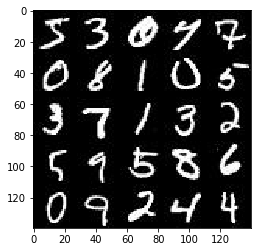

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

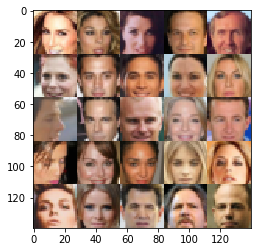

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import pickle as pkl

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    input_real = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim), name='input_z')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2, padding='same')
        r1 = tf.maximum(alpha*x1,x1)

        x2 = tf.layers.conv2d(r1,128,5,strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        r2 = tf.maximum(alpha*bn2,bn2)
        d2 = tf.nn.dropout(r2,keep_prob=keep_prob)

        x3 = tf.layers.conv2d(d2,256,5,strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        r3 = tf.maximum(alpha*bn3,bn3)
        d3 = tf.nn.dropout(r3,keep_prob=keep_prob)

        flat = tf.reshape(d3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out=tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # put the dropout because of overfitting
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z,7*7*512)
        
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        r1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(r1,256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        r2 = tf.maximum(alpha*x2, x2)
        d2 = tf.nn.dropout(r2,keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d_transpose(d2,128,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        r3 = tf.maximum(alpha*x3, x3)
        d3 = tf.nn.dropout(r3,keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(d3,out_channel_dim,5,strides=1,padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha = alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse= False, alpha = alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss 



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, 0.2)
    d_opt, g_opt =  model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    steps = 0
    samples = []
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                steps +=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr : learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr : learning_rate})
                
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                   
                    print("Epoch {}/{}...".format(e+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 200 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)    
                
        saver.save(sess, './generator.ckpt')
                
                
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 11.6436
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.6741
Epoch 1/2... Discriminator Loss: 2.6963... Generator Loss: 7.2609
Epoch 1/2... Discriminator Loss: 0.1200... Generator Loss: 3.8511
Epoch 1/2... Discriminator Loss: 7.3263... Generator Loss: 0.0066
Epoch 1/2... Discriminator Loss: 0.5271... Generator Loss: 2.5978
Epoch 1/2... Discriminator Loss: 1.0834... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.5638


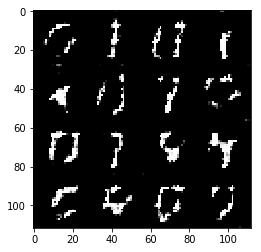

Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.9411
Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 1.5955
Epoch 1/2... Discriminator Loss: 1.6618... Generator Loss: 0.3463
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.1101
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 1.6744
Epoch 1/2... Discriminator Loss: 0.3080... Generator Loss: 2.1696
Epoch 1/2... Discriminator Loss: 0.4610... Generator Loss: 2.6569
Epoch 1/2... Discriminator Loss: 0.7969... Generator Loss: 1.4936


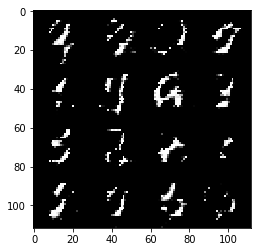

Epoch 1/2... Discriminator Loss: 0.3052... Generator Loss: 1.9737
Epoch 1/2... Discriminator Loss: 0.7175... Generator Loss: 1.0088
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.5245
Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 1.0858
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 0.8985... Generator Loss: 1.2380


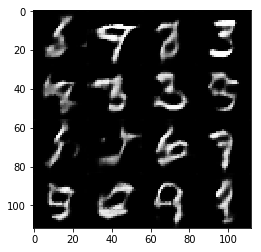

Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 0.7242... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 1.4492... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 1.0014
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 1.4793
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 1.0712
Epoch 1/2... Discriminator Loss: 1.5396... Generator Loss: 0.4380


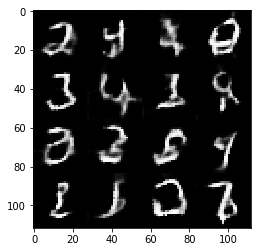

Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 1.3212
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 1.0372
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.7446... Generator Loss: 0.2644


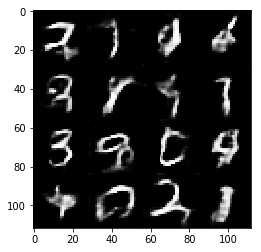

Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 2.2097
Epoch 1/2... Discriminator Loss: 0.7939... Generator Loss: 1.2820
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 0.9207
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 1.6741
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 0.7269... Generator Loss: 1.3285


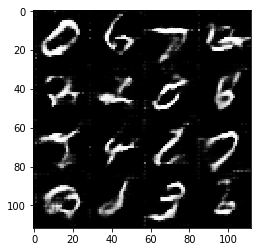

Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 1.1481
Epoch 1/2... Discriminator Loss: 0.6984... Generator Loss: 1.4908
Epoch 1/2... Discriminator Loss: 1.0600... Generator Loss: 1.5566
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.4433
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 0.9155... Generator Loss: 1.1698
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.4988


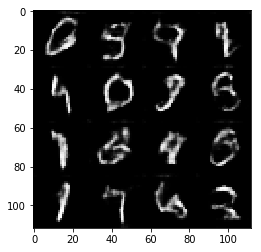

Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.4345
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 0.5267
Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 1.1558
Epoch 1/2... Discriminator Loss: 0.7245... Generator Loss: 1.1811
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 1.1896
Epoch 1/2... Discriminator Loss: 0.9176... Generator Loss: 1.4192
Epoch 1/2... Discriminator Loss: 1.9139... Generator Loss: 0.2491


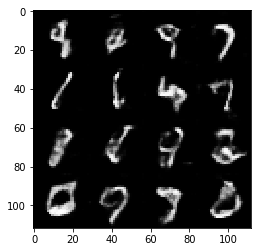

Epoch 1/2... Discriminator Loss: 0.7726... Generator Loss: 1.4974
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 1.2562
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 1.0030
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.1275
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.2502
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.9167
Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 1.5049
Epoch 1/2... Discriminator Loss: 0.6163... Generator Loss: 1.2711


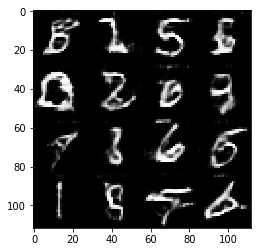

Epoch 1/2... Discriminator Loss: 1.1717... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 1.3693
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 0.8711... Generator Loss: 2.0540
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 0.9068
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.9599
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 0.6412
Epoch 2/2... Discriminator Loss: 0.6801... Generator Loss: 1.5477


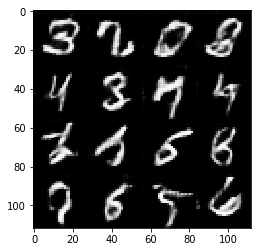

Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 0.8517
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.9810
Epoch 2/2... Discriminator Loss: 2.6262... Generator Loss: 0.1496
Epoch 2/2... Discriminator Loss: 0.4191... Generator Loss: 1.9896
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.7027
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 1.0160
Epoch 2/2... Discriminator Loss: 1.6678... Generator Loss: 0.4393
Epoch 2/2... Discriminator Loss: 0.7001... Generator Loss: 1.2512


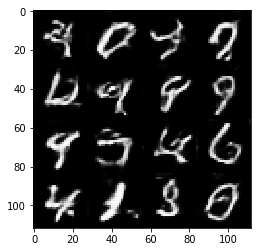

Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 0.6258... Generator Loss: 2.6563
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 3.6310
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 0.9519
Epoch 2/2... Discriminator Loss: 0.9563... Generator Loss: 1.5730
Epoch 2/2... Discriminator Loss: 0.6670... Generator Loss: 1.3619
Epoch 2/2... Discriminator Loss: 2.7487... Generator Loss: 0.1524


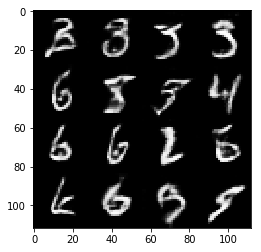

Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 1.2538
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 0.6491... Generator Loss: 1.3457
Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 2.0304
Epoch 2/2... Discriminator Loss: 1.0107... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 2.0097... Generator Loss: 0.2725
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.4216


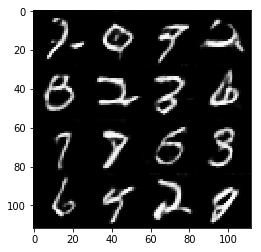

Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 1.4375
Epoch 2/2... Discriminator Loss: 0.7635... Generator Loss: 1.2499
Epoch 2/2... Discriminator Loss: 2.8177... Generator Loss: 0.0877
Epoch 2/2... Discriminator Loss: 1.8892... Generator Loss: 0.2888
Epoch 2/2... Discriminator Loss: 0.6217... Generator Loss: 1.2545
Epoch 2/2... Discriminator Loss: 0.4238... Generator Loss: 1.4884
Epoch 2/2... Discriminator Loss: 0.4162... Generator Loss: 2.1460
Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 1.7564


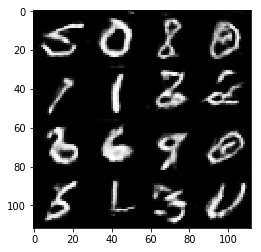

Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.2354
Epoch 2/2... Discriminator Loss: 0.5600... Generator Loss: 1.5903
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.7446
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 5.4125
Epoch 2/2... Discriminator Loss: 0.3849... Generator Loss: 2.0864
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 2.0418
Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 4.2622
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.1411


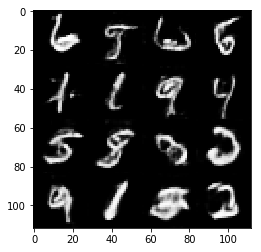

Epoch 2/2... Discriminator Loss: 0.5082... Generator Loss: 2.0017
Epoch 2/2... Discriminator Loss: 0.2687... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 0.1145... Generator Loss: 3.1427
Epoch 2/2... Discriminator Loss: 0.3922... Generator Loss: 2.2144
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 1.6985
Epoch 2/2... Discriminator Loss: 0.6788... Generator Loss: 1.2030


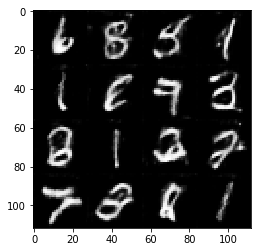

Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.6678
Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.9661
Epoch 2/2... Discriminator Loss: 0.3749... Generator Loss: 1.6652
Epoch 2/2... Discriminator Loss: 0.4159... Generator Loss: 1.6209
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 0.9635
Epoch 2/2... Discriminator Loss: 0.7848... Generator Loss: 2.6454
Epoch 2/2... Discriminator Loss: 1.8921... Generator Loss: 0.5510


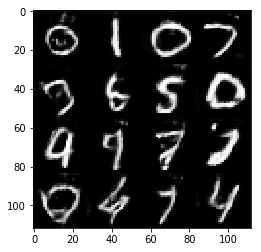

Epoch 2/2... Discriminator Loss: 0.5694... Generator Loss: 1.5010
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 1.2250
Epoch 2/2... Discriminator Loss: 0.7223... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 0.2291... Generator Loss: 1.9942
Epoch 2/2... Discriminator Loss: 0.4129... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.0395
Epoch 2/2... Discriminator Loss: 0.8010... Generator Loss: 1.5213


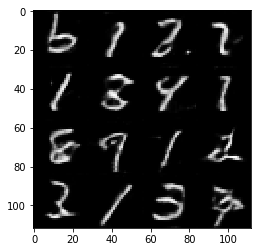

Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.8559
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 2.2463
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 3.9352... Generator Loss: 4.1877
Epoch 2/2... Discriminator Loss: 0.8661... Generator Loss: 1.1716
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.7232


In [19]:
batch_size = 32
z_dim = 128
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 2.4024
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.6358
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 0.2186... Generator Loss: 7.2557
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 2.8837
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 2.3852... Generator Loss: 2.9870


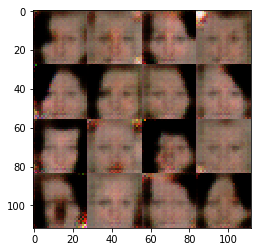

Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 2.3358... Generator Loss: 2.4070
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 1.9726... Generator Loss: 1.6963


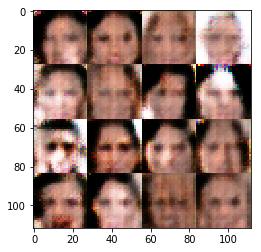

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.8760... Generator Loss: 0.2291
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.6296... Generator Loss: 0.3604
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.4319


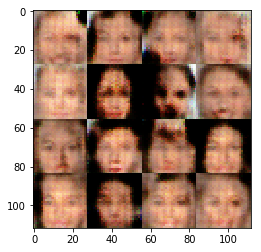

Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 2.7886... Generator Loss: 2.7135
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6456


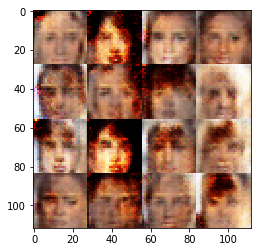

Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.8517... Generator Loss: 0.2532
Epoch 1/1... Discriminator Loss: 1.9322... Generator Loss: 0.2388


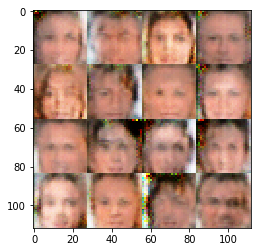

Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.3739
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.6845


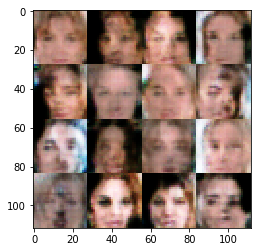

Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 2.0661... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.7786... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.8530... Generator Loss: 0.2632
Epoch 1/1... Discriminator Loss: 1.7402... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 1.6358


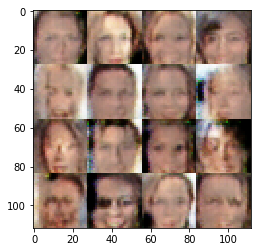

Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.7719


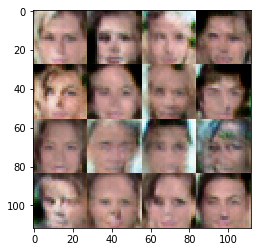

Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.3457
Epoch 1/1... Discriminator Loss: 1.9540... Generator Loss: 0.2190
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.5902


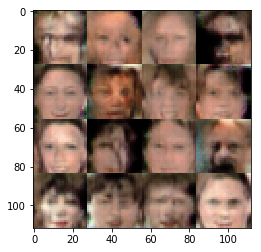

Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.6965... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.6758


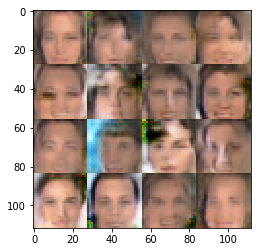

Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.7775... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.4390


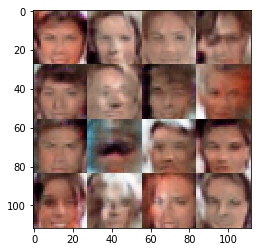

Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.6709


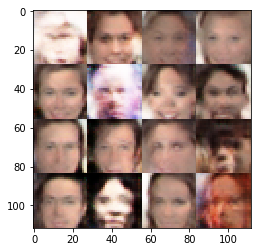

Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.5630


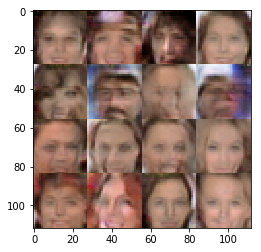

Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.6946... Generator Loss: 0.7609


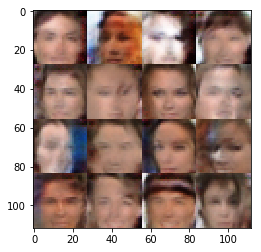

Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.3768


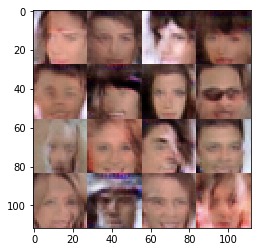

Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.4607


In [21]:
batch_size = 64
z_dim = 256
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.